In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 
from scipy.sparse import load_npz

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Libraries imported.")

# Load the processed data
X_train_tfidf = load_npz('../data/processed/X_train_tfidf.npz')
X_test_tfidf = load_npz('../data/processed/X_test_tfidf.npz')
y_train = pd.read_csv('../data/processed/y_train.csv').squeeze()
y_test = pd.read_csv('../data/processed/y_test.csv').squeeze()

print("Data loaded successfully.")
print(f"Training data shape: {X_train_tfidf.shape}")
print(f"Test data shape: {X_test_tfidf.shape}")

vectorizer = joblib.load('../models/tfidf_vectorizer.joblib')

print("Vectorizer loaded successfully.")

Libraries imported.
Data loaded successfully.
Training data shape: (35918, 10000)
Test data shape: (8980, 10000)
Vectorizer loaded successfully.


In [2]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(random_state=42, solver='liblinear')

# Train the model on the training data
print("Training the Logistic Regression model...")
lr_model.fit(X_train_tfidf, y_train)
print("Training complete.")

Training the Logistic Regression model...
Training complete.


In [3]:
# Make predictions on the unseen test data
y_pred_lr = lr_model.predict(X_test_tfidf)

# Print the classification report
print("\n--- Logistic Regression Classification Report ---")
print(classification_report(y_test, y_pred_lr, target_names=['Real (0)', 'Fake (1)']))


--- Logistic Regression Classification Report ---
              precision    recall  f1-score   support

    Real (0)       0.98      0.99      0.99      4284
    Fake (1)       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



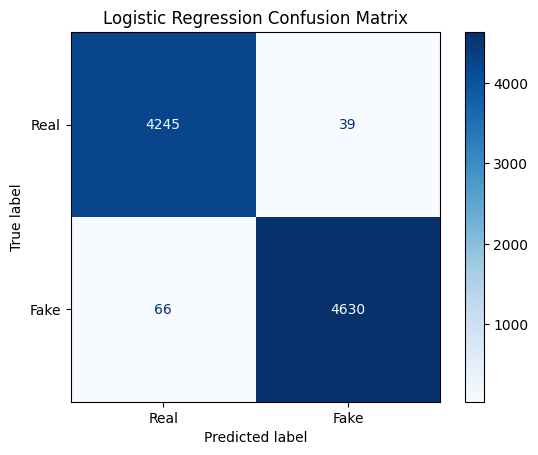

In [4]:
# Generate the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Real', 'Fake'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

Training the Linear SVM model...
Training complete.

--- Linear SVM Classification Report ---
              precision    recall  f1-score   support

    Real (0)       1.00      1.00      1.00      4284
    Fake (1)       1.00      1.00      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



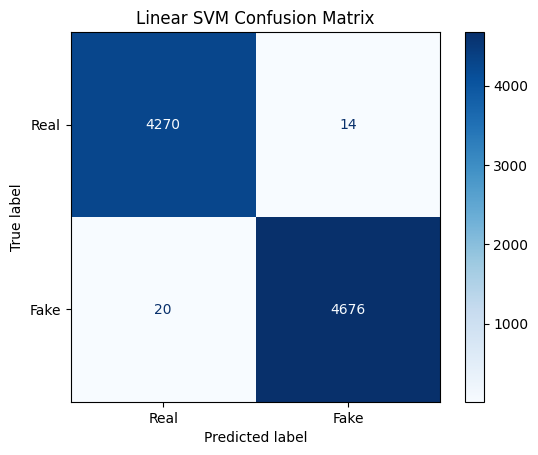

In [5]:
# Initialize the LinearSVC model
svm_model = LinearSVC(random_state=42, dual=False)

# Train the model
print("Training the Linear SVM model...")
svm_model.fit(X_train_tfidf, y_train)
print("Training complete.")

# Make predictions
y_pred_svm = svm_model.predict(X_test_tfidf)

# Print the classification report
print("\n--- Linear SVM Classification Report ---")
print(classification_report(y_test, y_pred_svm, target_names=['Real (0)', 'Fake (1)']))

# Plot the confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Real', 'Fake'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Linear SVM Confusion Matrix")
plt.show()

In [6]:
def get_top_features(model, feature_names, n=20):
    """
    Gets the top n features (words/phrases) that are most predictive for
    each class, based on the model's coefficients.
    """
    # The model.coef_[0] contains the weights for all features
    coefs = model.coef_[0]

    # Create a dataframe of features and their coefficients
    df_coef = pd.DataFrame(coefs, index=feature_names, columns=['coefficient'])

    # Sort by coefficient value
    df_coef = df_coef.sort_values('coefficient')

    # Get the top n negative (real) and top n positive (fake)
    top_real_features = df_coef.head(n)
    top_fake_features = df_coef.tail(n)

    return top_real_features, top_fake_features

def plot_top_features(top_real, top_fake):
    """
    Plots the top features for real and fake news.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

    # Plot for Real News (Negative Coefficients)
    top_real.plot(kind='barh', ax=ax1, legend=None, color='cornflowerblue')
    ax1.set_title('Top 20 Predictors of REAL News')
    ax1.set_xlabel('Coefficient (Negative Weight)')

    # Plot for Fake News (Positive Coefficients)
    top_fake.plot(kind='barh', ax=ax2, legend=None, color='tomato')
    ax2.set_title('Top 20 Predictors of FAKE News')
    ax2.set_xlabel('Coefficient (Positive Weight)')

    plt.tight_layout()
    plt.show()

# Get the feature names from our loaded vectorizer
feature_names = vectorizer.get_feature_names_out()

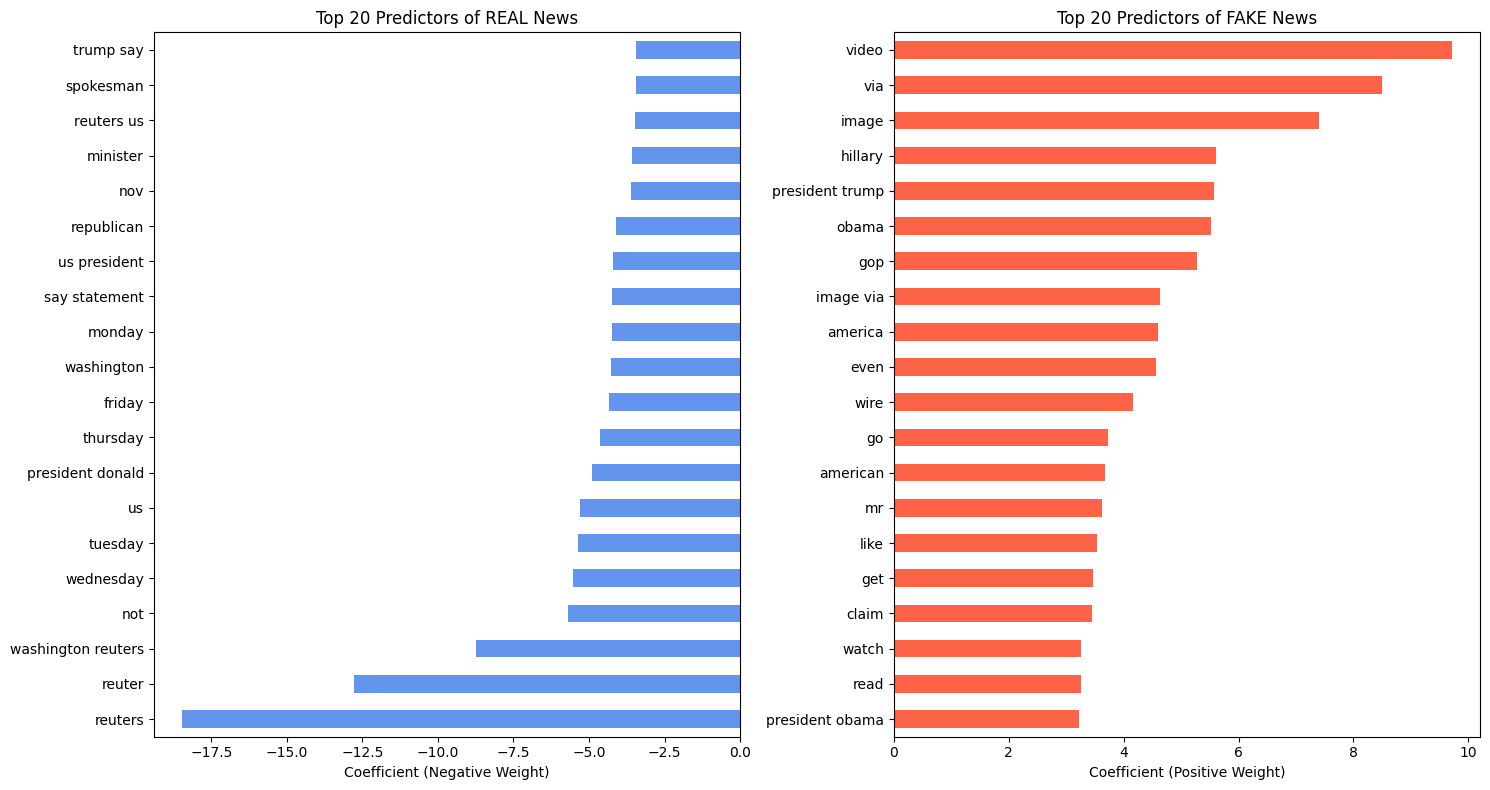

In [7]:
# For Logistic Regression
lr_top_real, lr_top_fake = get_top_features(lr_model, feature_names)
plot_top_features(lr_top_real, lr_top_fake)

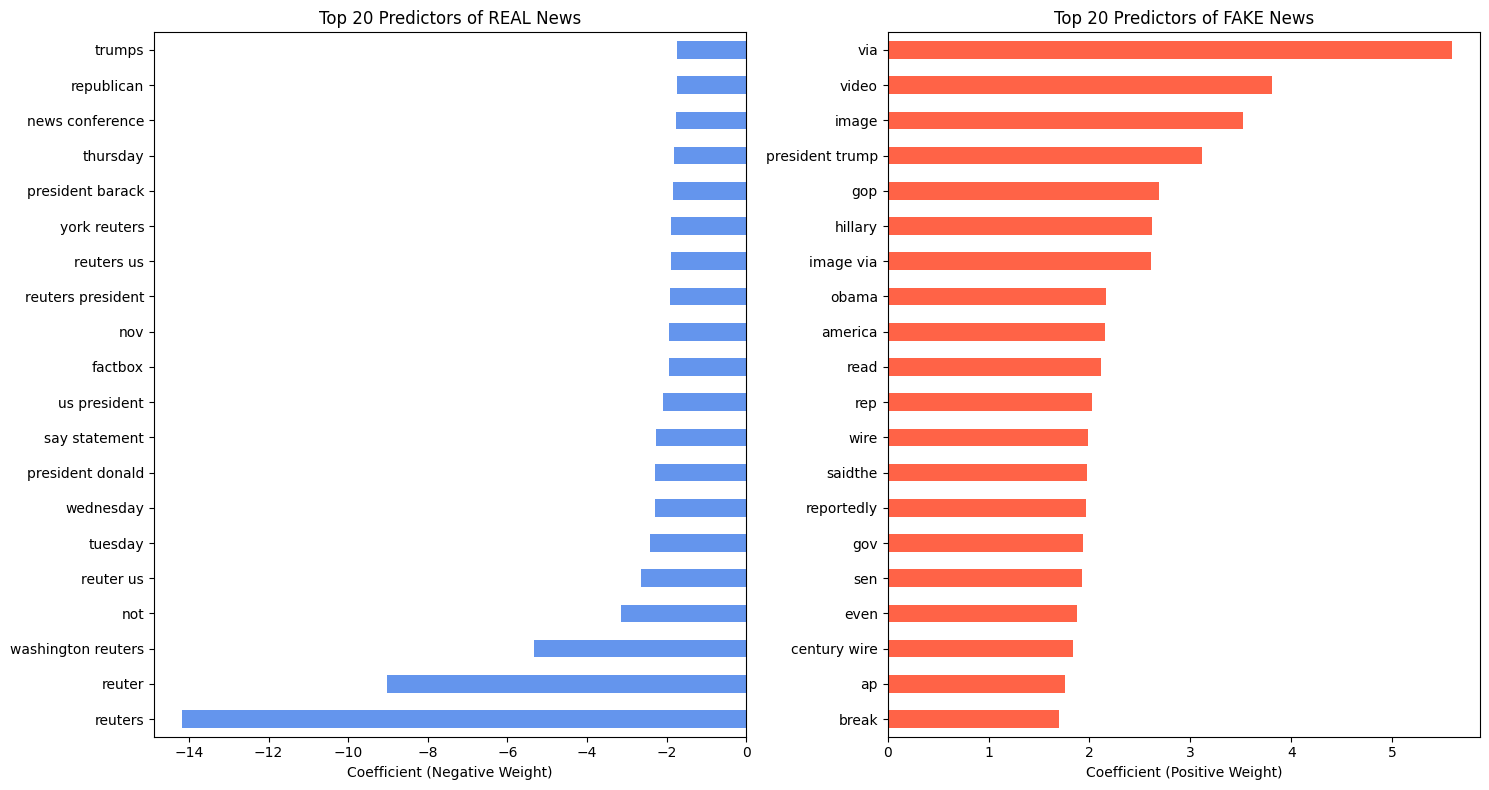

In [8]:
# For Linear SVM
svm_top_real, svm_top_fake = get_top_features(svm_model, feature_names)
plot_top_features(svm_top_real, svm_top_fake)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib

# We need the original raw text data for this step
# Let's load the interim dataset again
df = pd.read_csv('../data/interim/news_dataset.csv')

# Handle potential NaNs and combine text
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')
df['full_text'] = df['title'] + " " + df['text']

# Define features and target
X = df['full_text']
y = df['label']

# Create the full pipeline
# NOTE: We use the best parameters we found/used earlier.
final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=10000, min_df=5, max_df=0.8, stop_words='english')),
    ('clf', LogisticRegression(random_state=42, solver='liblinear'))
])

# Retrain the pipeline on the ENTIRE dataset
print("Training the final pipeline on all data...")
final_pipeline.fit(X, y)
print("Final pipeline training complete.")

# Save the final pipeline to the models folder
joblib.dump(final_pipeline, '../models/final_news_pipeline.joblib')

print("\nFinal pipeline saved to models/final_news_pipeline.joblib")

Training the final pipeline on all data...
Final pipeline training complete.

Final pipeline saved to models/final_news_pipeline.joblib
